<a href="https://colab.research.google.com/github/dohyeon-kim012/MachineLearning-DeepLearning/blob/main/DeepLearning/20.RNN_LSTM_Seq2Seq%20%EA%B8%B0%EB%B3%B8%20%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sequence to Sequence = Many to Many

# LSTM의 `return_sequences`, `return_state` 이해하기

- `return_sequences` : 매 time step의 출력 여부 결정
- `return_state` : 가장 마지막 state 출력 여부 결정

In [1]:
import numpy as np
from tensorflow.keras.layers import LSTM

In [2]:
sample_train = np.random.randn(1, 4, 5) 
# (N, L, I) = (데이터개수, 최대타입스텝, input-dim(입력 특성 차원))
# LSTM은 3차원으로 들어가야 함

`return_sequences = False`, `return_state = False` 확인하기

- `last_hidden_state`

In [3]:
# 각 cell의 뉴런 개수를 3으로 정함
# 가장 마지막 hidden state만 반환된다
last_hidden_state = LSTM(3, return_sequences=False, return_state=False)(sample_train)
print(last_hidden_state)

tf.Tensor([[ 0.2868083   0.22303279 -0.20539846]], shape=(1, 3), dtype=float32)


`return_sequences = False`, `return_state = True` 확인하기

time_stpe마다의 결과물은 없고, `context Vector`을 써야할 때  
: `Encoder`에서 사용

- `hidden_states` = `last_hidden_state` ( 두 가지가 같아짐 )
- `last_cell_state`

In [4]:
# last_hidden_state뿐 아니라 hidden_states와 last_cell_state도 반환된다
hidden_states, last_hidden_state, last_cell_state = LSTM(3, return_sequences=False, return_state=True)(sample_train)
print("hidden_states : {}".format(hidden_states))
print("last_hidden_state : {}".format(last_hidden_state))
print("last_cell_state : {}".format(last_cell_state))

hidden_states : [[-0.37966824 -0.272096   -0.41054803]]
last_hidden_state : [[-0.37966824 -0.272096   -0.41054803]]
last_cell_state : [[-0.90767366 -0.58981955 -1.0130671 ]]


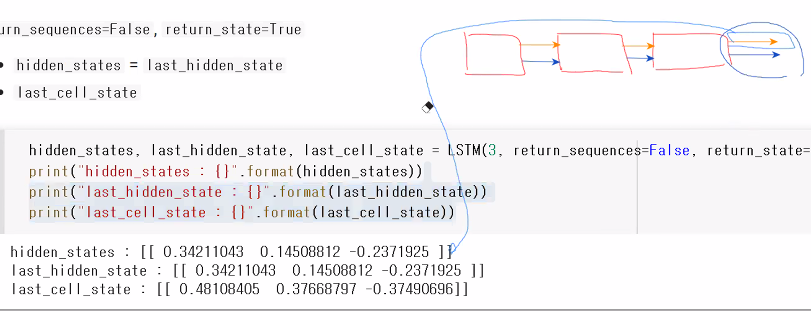

`return_sequences = True`, `return_state=False` 확인하기

return되는 sequence는 ( 1, 4, 3 ) 으로 ( batch 수, time steps, 뉴런 개수 ) 로 나온다

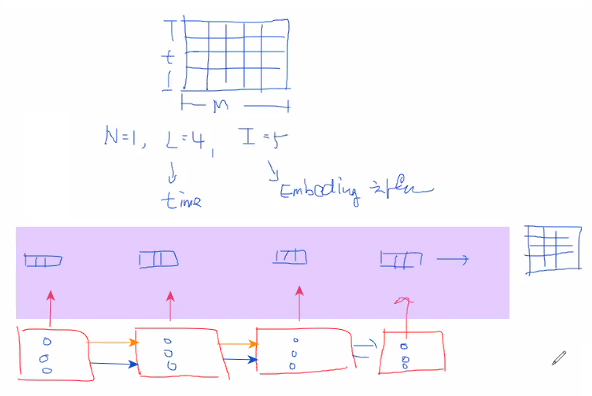

In [5]:
hidden_states = LSTM(3, return_sequences=True, return_state=False)(sample_train)
print("hidden_states : {} / shape : {}".format(hidden_states, hidden_states.shape))

hidden_states : [[[ 0.05556558  0.02455324 -0.05791529]
  [ 0.00495502  0.02219662 -0.1499682 ]
  [ 0.15052502 -0.27992246 -0.06171817]
  [ 0.3565307  -0.11839477 -0.06129659]]] / shape : (1, 4, 3)


`return_sequences=True`,`return_state=True`

In [6]:
# sequence마다의 hidden_states 값을 확인할 수 있음
hidden_states, last_hidden_state, last_cell_state = LSTM(3, return_sequences=True, return_state=True)(sample_train)
print("hidden_states : {}".format(hidden_states))
print("last_hidden_state : {}".format(last_hidden_state))
print("last_cell_state : {}".format(last_cell_state))

hidden_states : [[[ 0.09310823  0.23721913  0.02149235]
  [ 0.05851769  0.29495737 -0.00830224]
  [ 0.0565284   0.04432812  0.12837707]
  [ 0.17236295  0.02498664  0.15486377]]]
last_hidden_state : [[0.17236295 0.02498664 0.15486377]]
last_cell_state : [[0.4083     0.04845178 0.24047397]]


# Seq2Seq로 챗봇 만들기

In [7]:
!pip install konlpy

In [8]:
import random # 나중에 셔플링 할 때 사용할 것임
import tensorflow as tf
from konlpy.tag import Okt

## 하이퍼 파라미터

In [9]:
num_epochs = 200
vocab_size = 2000

## Encoder 정의

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.emb = tf.keras.layers.Embedding(vocab_size, 64) # embedding 차원 = 64

        # 제일 마지막 state를 리턴해야 context vector가 나온다
        self.lstm = tf.keras.layers.LSTM(512, return_sequences=False, return_state=True)

    def call(self, x, training=False):
        # 임베딩
        x = self.emb(x)

        # LSTM 호출하는데 Encoder에서는 context vector만 얻어내면 되기 때문에 각 time별 return 값은 필요 없음
        _, h, c = self.lstm(x)
        
        # context vector return (lstm이기 때문에 last hidden state와 last cell state까지 포함)
        return h, c

## Decoder 정의

1. `LSTM layer`에서는 `return_sequences` 와 `return_state` 둘 다 `True`로 두어야 함  
    - 매 층마다 출력값인 x를 다음 층에 입력값으로 넣어줘야 하기 때문
2. `Decoder`에서는 `Dense layer`도 필요함 
    - 각 셀마다 `vacab_size`만큼의 output를 내고
    - `softmax`를 사용해 어떤 단어가 추정되었을지를 계산
3. return 값 
    - x : 밀린 값 shifted ( 이전 출력값을 밀어서 다음 입력값으로 사용한다 )
    - h : last hidden state
    - c : last cell state
3. `initial_state` : 초기화 할 `hidden_state`, `cell_state`를 지정

In [31]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        # 임베딩 테이블이 같을 필요는 없음
        # 만약 여러 언어를 다룬다면 각 언어 별로 임베딩 필요함
        self.emb = tf.keras.layers.Embedding(vocab_size, 64)
        self.lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, training=False):
        x, h, c = inputs
        x = self.emb(x) # 입력한 단어에 대한 임베딩 벡터

        # y_ : 해당 시퀀스의 hidden_state = h
        y_, h, c = self.lstm(x, initial_state=[h, c])
        # y : 다음 step으로 넘어가는 값 (y_의 dense 출력물, h, c 모두 넘어감)
        y = self.dense(y_)

        return y, h, c

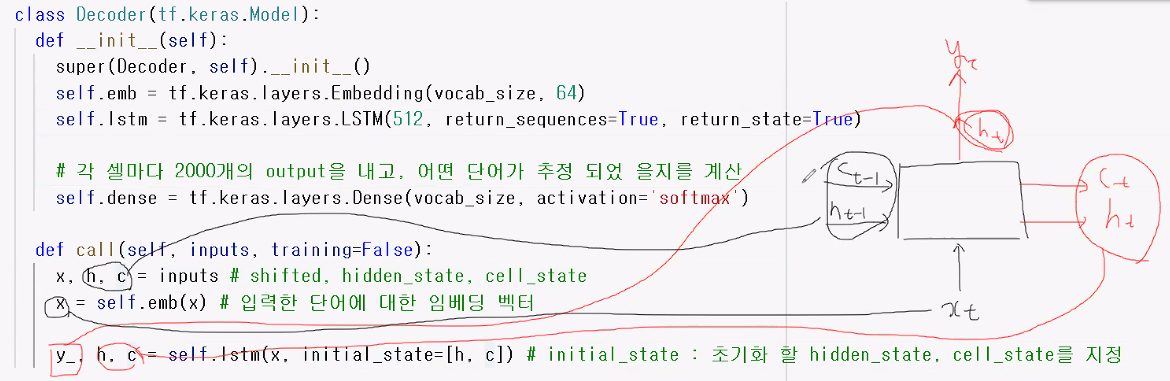

## Seq2Seq ( 메인 모델 ) 정의

`def call`
1. 훈련에서는 Teacher Forching 때문에 정답 ( y ) 이 들어온다
2. 테스트 때는 x만 들어와야 한다

In [12]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, sos, eos): # sos = 시작값, eos = 종료값
        super(Seq2Seq, self).__init__()
        self.sos = sos # decoder에서 사용되어질 sos
        self.eos = eos # encoder에서 사용되어질 eos
        
        self.enc = Encoder()
        self.dec = Decoder()

    def call(self, inputs, training=False):
        if training:
            x, y = inputs # x : encoder로 들어갈 데이터(output_labesls), y : decoder로 들어갈 데이터 (shifted labels)
            h, c = self.enc(x) # x에 대한 context vector 등장
            # y.shape : (N 배치, 64 개의 단어 + 1 , 64 개씩)
            y, _, __ = self.dec((y, h, c)) # teacher forcing / Decoder의 입력으로 Shifted Output을 넣어줌

            return y # 훈련된 decoder의 결과값 나옴
        
        else: # 테스트 때는 x 값만 받기
            x = inputs
            h, c = self.enc(x) # last_cell_state, last_hidden_state

            # <sos> 입력
            # 1. <sos> 토큰을 tensor 배열화 시켜야 함
            y = tf.convert_to_tensor(self.sos) # 0 rank tensor로 변환
            y = tf.reshape(y, (1, 1)) # <sos>가 (1배치, 1타입스텝) 형식으로 변환, embedding레이어에 넣어주기

            # 최대 입력 길이 만큼의 공간을 미리 만들어놓자 (예측된 데이터를 쌓아놓기 위해서)
            seq = tf.TensorArray(tf.int32, 64) # 64개의 텐서 배열 만들기

            # tf.range : tensorflow의 session 환경에서 for문을 더 빠르게 돌릴 수 있다
            for idx in tf.range(64):
                # 가장 처음 <sos>, 이후 인코더의 h, c(context vector)가 들어간다
                y, h, c = self.dec([y, h, c]) # 리턴받는 y는 softmax 결과
                y = tf.cast(tf.argmax(y, axis=-1), dtype=tf.int32)

                y = tf.reshape(y, (1, 1)) 
                # 한 문장 들어가서 하나의 결과, 1배치가 들어가니까 나오는 것도 하나 -> (1배치, 1단어)로 reshape

                seq = seq.write(idx, y) # 순서대로 write

                if y == self.eos:
                    break
            
            return tf.reshape(seq.stack(), (1, 64))

## 학습, 테스트 루프 정의

- `train_step`
    1. labels
        - labels는 `<sos>`, `<eos>`를 포함한 정보 전체

        - output_labels : `<sos>` 제외 , `<eos>` 포함 -> 각 층의 **출력값**
        ```
        labels[:, 1:]
        ```
        - shifted_labels : `<sos>` 포함 , `<eos>` 제외 -> 각 층의 **입력값**
        ```
        labels[:, :-1]
        ```  
    2. GradientTape
        - inputs : x의 역할 , Encoder에 들어감
        - shifted_labels : Encoder가 예측해야 할 데이터
2. `test_step`  

    값의 확인을 위해 return받기 / 입력 데이터만 주고 추론은 알아서 하도록

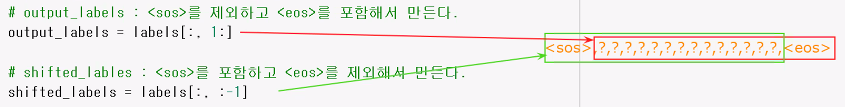

In [33]:
@tf.function
def train_step(model, inputs, labels, loss_object, optimizer, train_loss, train_accuracy):
    output_labels = labels[:, 1:] # 출력값
    shifted_labels = labels[:, :-1] # 입력값

    with tf.GradientTape() as tape:
        predictions = model([inputs, shifted_labels], training=True) # 예측을 하고
        loss = loss_object(output_labels, predictions) # 정답이 이거였어~ 라고 이야기하기

    # 기울기 계산
    gradients = tape.gradient(loss, model.trainable_variables)
    # 오차역전파 - weight 업데이트
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # loss와 accuracy 업데이트
    train_loss(loss)
    train_accuracy(output_labels, predictions)

@tf.function
def test_step(model, inputs):
    # 입력값만 주고 결과 확인을 위해 추론값 return받기
    return model(inputs, training=False)

## 데이터셋 준비 
`chatbot_data.csv` ( http://www.aihub.or.kr )

In [14]:
from konlpy.tag import Okt

dataset_file = 'chatbot_data.csv'
okt = Okt()

In [15]:
with open(dataset_file, 'r') as file:
    lines = file.readlines()
    seq = [" ".join(okt.morphs(line)) for line in lines] # 한 줄씩 형태소 분석 후, 다시 한 줄로 합쳐주기

In [16]:
seq[:6]

['아이스 아메리카노 하나요 \n',
 '테이크아웃 하실 건가 요 ? \n',
 '저 카푸치노 로 주문 할게요 \n',
 '시럽 은 얼마나 뿌려 드릴 까요 ? \n',
 '저 도장 다 모았는데 나중 에 써도 되나요 ? \n',
 '네 다음 에 써도 됩니다 \n']

`seq` 확인 결과 이 데이터는 '주문' , '응답' 의 형태로 되어 있는 것을 알 수 있음  
따라서, 두 가지를 분리할 것임

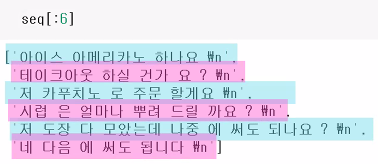

In [17]:
questions = seq[::2]
answers = ['\t ' + lines for lines in seq[1::2]]
# \t : <sos> , 대답 앞 쪽에 붙여서 대답을 분류해내는 수단으로 쓸 것

print(questions[:3])
print(answers[:3])

['아이스 아메리카노 하나요 \n', '저 카푸치노 로 주문 할게요 \n', '저 도장 다 모았는데 나중 에 써도 되나요 ? \n']
['\t 테이크아웃 하실 건가 요 ? \n', '\t 시럽 은 얼마나 뿌려 드릴 까요 ? \n', '\t 네 다음 에 써도 됩니다 \n']


- `\t` : `<sos>`  
- `\n` : `<eos>`

### 데이터 잘라내기

In [18]:
num_samples = len(questions) # 500개
term = list(range(num_samples))
print("before shuffle : {}".format(term[:10]))

# 랜덤 시드 고정
random.seed(0)
random.shuffle(term)
print("after shuffle : {}".format(term[:10]))

before shuffle : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
after shuffle : [419, 459, 130, 431, 370, 26, 201, 56, 366, 108]


- questions : 입력 데이터 ( inputs )
- answers : 예측 레이블 ( outputs )

In [19]:
train_q = [] # X_train
train_a = [] # y_train

test_q = [] # X_test
test_a = [] # y_test

In [34]:
test_ratio = 0.2 
test_cnt = int(len(questions) * test_ratio)

train_indices = term[test_cnt:]
test_indices = term[:test_cnt]

for idx in train_indices:
    train_q.append(questions[idx])
    train_a.append(answers[idx])

for idx in test_indices:
    test_q.append(questions[idx])
    test_a.append(answers[idx])

```python
for idx, qna in enumerate(zip(questions, answers)):
    q, a = qna
    
    if term[idx] > num_samples // 5 : 
```

In [21]:
test_q[:3], test_a[:3]

(['사이 즈 업 해서 주세요 \n',
  '캐러멜 드리블 이랑 통 잡아 칩이요 \n',
  '시즌 메뉴 와 함께 구성 되어 있는 세트 메뉴 가 있나요 ? \n'],
 ['\t 네 결제 는 어떻게 도 와 드릴 까요 ? \n',
  '\t 6700원 결제 도 와 드리겠습니다 \n',
  '\t 네 치즈 케이크 와 시즌 메뉴 두 잔 으로 구성 된 세트 메뉴 있습니다 \n'])

### 토크나이징

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')

In [23]:
tokenizer.fit_on_texts(train_q + train_a) # 질문과 대답의 모든 내용을 토큰화
print(tokenizer.word_index)

{'\n': 1, '\t': 2, '네': 3, '주세요': 4, '로': 5, '아메리카노': 6, '는': 7, '에': 8, '아이스': 9, '도': 10, '요': 11, '잔': 12, '이': 13, '한': 14, '드릴': 15, '까요': 16, '은': 17, '입니다': 18, '사이즈': 19, '가': 20, '있나요': 21, '결제': 22, '수': 23, '하나': 24, '있습니다': 25, '와': 26, '드시고': 27, '해주세요': 28, '할게요': 29, '으로': 30, '라테': 31, '추가': 32, '따뜻한': 33, '주문': 34, '사용': 35, '음료': 36, '되나요': 37, '여기': 38, '아니요': 39, '거': 40, '얼마': 41, '개': 42, '그럼': 43, '카드': 44, '랑': 45, '드리겠습니다': 46, '케이크': 47, '어떤': 48, '걸': 49, '포인트': 50, '가시나요': 51, '한잔': 52, '할인': 53, '적립': 54, '다': 55, '커피': 56, '더': 57, '인가요': 58, '쿠폰': 59, '가요': 60, '드릴게요': 61, '티': 62, '건': 63, '가능합니다': 64, '알겠습니다': 65, '에서': 66, '가능한가요': 67, '매장': 68, '를': 69, '진동': 70, '면': 71, '벨': 72, '안': 73, '번호': 74, '만': 75, '에요': 76, '메뉴': 77, '하나요': 78, '디카': 79, '페인': 80, '건가': 81, '샷': 82, '있어요': 83, '됩니다': 84, '테이크아웃': 85, '예요': 86, '스무디': 87, '게': 88, '카페라테': 89, '두': 90, '같이': 91, '자몽': 92, '하고': 93, '치즈케이크': 94, '제일': 95, '뭐': 96, '카페모카': 97, '기프티콘': 98, '세트':

#### 정수 인코딩

In [35]:
train_q_seq = tokenizer.texts_to_sequences(train_q)
train_a_seq = tokenizer.texts_to_sequences(train_a)

test_q_seq  = tokenizer.texts_to_sequences(test_q)
test_a_seq  = tokenizer.texts_to_sequences(test_a)

In [25]:
train_q_seq[:3], train_a_seq[:3]

([[85, 12, 30, 4, 1], [3, 239, 1], [3, 300, 301, 47, 4, 1]],
 [[2, 627, 628, 629, 73, 66, 630, 631, 35, 113, 23, 378, 1],
  [2, 57, 162, 63, 139, 60, 1],
  [2, 36, 7, 227, 5, 15, 16, 1]])

#### 패딩 후 최종 데이터 정리

In [36]:
# 문장의 최대길이는 64로 설정했음
X_train = pad_sequences(
    train_q_seq,
    value=0,
    padding='pre', # encoder의 입력 데이터이기 때문에, 'pre' padding임
    maxlen=64 # <eos> 포함 (<sos> 제외) -> 없어도 되긴 하지만, 개념적으로는 필요
)

y_train = pad_sequences(
    train_a_seq,
    value=0,
    padding='post', # decoder의 출력 데이터이기 때문
    maxlen=65 # <sos>, <eos> 토큰을 고려
    # 1) <sos>, ., ., .. - 64개 / 2) .., ., ., <eos> - 64개
    #   ---> 실제 예측할 데이터는 63개임!!
)

X_test = pad_sequences( test_q_seq, value=0, padding='pre', maxlen=64 )
y_test = pad_sequences( test_a_seq, value=0, padding='post', maxlen=65 )

In [27]:
X_train[0], y_train[0]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 85, 12, 30,  4,  1], dtype=int32),
 array([  2, 627, 628, 629,  73,  66, 630, 631,  35, 113,  23, 378,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32))

`prefetch` : 데이터를 미리 저장할 공간을 의미  
`prefetch(1024)` : 1024 byte의 데이터 ...

In [37]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(32).prefetch(1024)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1).prefetch(1024)

## 학습 환경 정의

모델 생성, 손실 함수, 최적화 알고리즘, 평가지표 정의

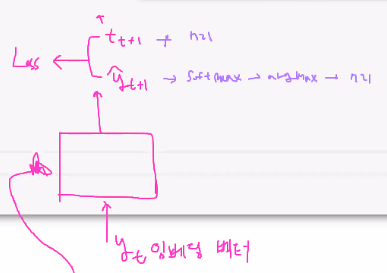

In [38]:
# 모델 생성
model = Seq2Seq(
    sos=tokenizer.word_index['\t'],
    eos=tokenizer.word_index['\n']
)

# Loss 선정 => 정수 인코딩된 결과를 t로 사용, softmax 및 argmax를 이용한 정수값을 예측으로 쓰니까 sparse_categorical_crossentropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# 모델 평가 방식
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

## 학습 루프 동작

In [43]:
EPOCHS = 200
for epoch in range(EPOCHS):
    for seqs, labels in train_ds:
        train_step(model, seqs, labels, loss_object, optimizer, train_loss, train_accuracy)

    print("Epoch : {}, Loss : {:.3f}, Accuracy : {:.3f}".format(epoch+1,train_loss.result(),train_accuracy.result()*100))
    # valid는 사람이 직접 판단할 것이기 때문에 필요 없음

    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch : 1, Loss : 0.817, Accuracy : 90.303
Epoch : 2, Loss : 0.506, Accuracy : 91.359
Epoch : 3, Loss : 0.470, Accuracy : 91.744
Epoch : 4, Loss : 0.446, Accuracy : 92.271
Epoch : 5, Loss : 0.430, Accuracy : 92.479
Epoch : 6, Loss : 0.418, Accuracy : 92.559
Epoch : 7, Loss : 0.408, Accuracy : 92.662
Epoch : 8, Loss : 0.400, Accuracy : 92.699
Epoch : 9, Loss : 0.393, Accuracy : 92.789
Epoch : 10, Loss : 0.387, Accuracy : 92.873
Epoch : 11, Loss : 0.379, Accuracy : 92.967
Epoch : 12, Loss : 0.373, Accuracy : 93.064
Epoch : 13, Loss : 0.367, Accuracy : 93.145
Epoch : 14, Loss : 0.360, Accuracy : 93.207
Epoch : 15, Loss : 0.353, Accuracy : 93.277
Epoch : 16, Loss : 0.347, Accuracy : 93.350
Epoch : 17, Loss : 0.340, Accuracy : 93.457
Epoch : 18, Loss : 0.333, Accuracy : 93.520
Epoch : 19, Loss : 0.325, Accuracy : 93.598
Epoch : 20, Loss : 0.318, Accuracy : 93.678
Epoch : 21, Loss : 0.312, Accuracy : 93.756
Epoch : 22, Loss : 0.305, Accuracy : 93.779
Epoch : 23, Loss : 0.297, Accuracy : 93.8

Accuracy가 좋은 이유?? : `Teacher Forcing`

## 테스트 루프 만들기

`sequences_to_texts` : 정수인코딩된 결과를 text로 바꿔주는 역할

In [44]:
for test_seq, test_labels in test_ds:
  prediction = test_step(model, test_seq)
  
  test_q = tokenizer.sequences_to_texts(test_seq.numpy()) # 질문
  test_a = tokenizer.sequences_to_texts(test_labels.numpy()) # 실제 대답
  test_p = tokenizer.sequences_to_texts(prediction.numpy()) # 챗봇의 대답

  print("______")
  print("질문 : \t{}".format(test_q))
  print("실제 대답 : {}".format(test_a))
  print("챗봇 대답 : {}".format(test_p))

______
질문 : 	['사이 즈 업 해서 주세요 \n']
실제 대답 : ['\t 네 결제 는 어떻게 도 와 드릴 까요 \n']
챗봇 대답 : ['네 알겠습니다 \n']
______
질문 : 	['캐러멜 드리블 이랑 통 잡아 \n']
실제 대답 : ['\t 결제 도 와 드리겠습니다 \n']
챗봇 대답 : ['네 가능합니다 \n']
______
질문 : 	['시즌 메뉴 와 함께 되어 있는 세트 메뉴 가 있나요 \n']
실제 대답 : ['\t 네 치즈 케이크 와 시즌 메뉴 두 잔 으로 세트 메뉴 있습니다 \n']
챗봇 대답 : ['기프티콘 으로 대체 할 수 있는 시즌 메뉴 는 없습니다 \n']
______
질문 : 	['아메리카노 1 잔 주세요 \n']
실제 대답 : ['\t 매장 에서 드시고 가시나요 \n']
챗봇 대답 : ['음료 사이즈 말씀 해주세요 \n']
______
질문 : 	['그럼 와 아이스 아메리카노 로 할게요 \n']
실제 대답 : ['\t 더 필요하신 건 없나요 \n']
챗봇 대답 : ['결제 는 어떻게 도 와 드릴 까요 \n']
______
질문 : 	['밀크 티 있나요 \n']
실제 대답 : ['\t 네 있습니다 \n']
챗봇 대답 : ['네 가능하세요 \n']
______
질문 : 	['네 기프티콘 여기 있어요 \n']
실제 대답 : ['\t 아메리카노 기프티콘 사용 되었습니다 \n']
챗봇 대답 : ['더 필요한 건 없으세요 \n']
______
질문 : 	['네 오늘 의 커피 로 주세요 \n']
실제 대답 : ['\t 네 사이즈 는 어떤 걸 로 주문 넣어 드릴 까요 \n']
챗봇 대답 : ['네 적립 이나 할인 되는 카드 있으세요 \n']
______
질문 : 	['포인트 사용 없이 적립 만 할게요 \n']
실제 대답 : ['\t 네 멤버십 카드 주시 면 도 와 드리겠습니다 \n']
챗봇 대답 : ['쿠폰 주시 면 도 와 드리겠습니다 \n']
______
질문 : 	['네 감사합니다 \n']
실제 대답 : ['\t 따뜻한 카페라테 한